In [ ]:
# pour naviguer dans les répertoires
import os 
# pour manipuler les DataFrames
import pandas as pd
# pour ouvrir et inspecter les images
from PIL import Image

import numpy as np

# -----------------------------
# Parcours du dataset et collecte des métadonnées
# -----------------------------

# Répertoire de base où sont stockées les variantes d’images
base_dir = "../dataset/plantvillage/data/plantvillage dataset/segmented"
# liste qui accueillera un dict par image
data = []

print("==> base_dir =", base_dir)
import glob
# recherche récursive : tous les .jpg/.png/etc sous segmented
pattern = os.path.join(base_dir, "*", "*.*")
all_seg_imgs = glob.glob(pattern)
print("Images trouvées dans segmented (glob) :", len(all_seg_imgs))

#On parcourt les variantes/sous-dossiers "color", "grayscale", "segmented"

for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
            
    if os.path.isdir(folder_path):
        # Extraire l’espèce et la maladie depuis le nom de dossier
        # Exemple : "Apple_scab__Powdery_mildew"
        if '__' in folder_name:
            species, disease = folder_name.split('__', 1)
        else:
            species, disease = folder_name, 'unknown'

        # Parcours de toutes les images dans ce dossier
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
                    
            try:
                # Ouverture sécurisée de l’image
                with Image.open(image_path) as img:
                    # conversion systématique en RGB
                    img = img.convert('RGB')

                    # dimensions en pixels
                    width, height = img.size
                    # mode de couleur, ex RGB, grayscale,..# sera toujours 'RGB' après conversion
                    mode = img.mode  

                    # 2) Convertit en tableau NumPy et calcule mean/std par canal
                    arr = np.array(img)  # shape = (H, W, 3)
                    mean_R, mean_G, mean_B = arr.mean(axis=(0,1)).tolist()
                    std_R,  std_G,  std_B  = arr.std(axis=(0,1)).tolist()

            except Exception as e:
                # En cas d’erreur (fichier corrompu…), on l’affiche et on passe
                print(f"Erreur avec {image_path} : {e}")
                continue

            # On stocke toutes les infos extraites dans un dict
            data.append({
                'image_path': image_path.replace('\\', '/'),
                #'variant': variant,  # color, grayscale ou segmented
                'species': species,  # nom de l’espèce
                'disease': disease, # type de maladie (ou 'unknown')
                'width': width, # largeur
                'height': height, # hauteur
                'mode': mode,  # ex. 'RGB' 
                # colonnes couleur globale
                #'mean_R': mean_R, 'mean_G': mean_G, 'mean_B': mean_B,
                #'std_R':  std_R,  'std_G':  std_G,  'std_B':  std_B
            })

# Création du DataFrame pandas à partir de la liste de dicts
df = pd.DataFrame(data)
# Affichage des premières lignes pour vérifier la structure
print(df.head())
# Liste des colonnes disponibles dans le DF
print("\nColonnes disponibles :", df.columns.tolist())
# Statistiques descriptives sur les dimensions
print("\nDimensions des images :")
print(df[['width', 'height']].describe())

# Compte des différents modes d’image (RGB, L pour grayscale, etc.)
print("\nTypes d’image :", df['mode'].value_counts())
# Répartition du nombre d’images par variante (color, grayscale, segmented)
#print("\nRépartition des variantes :", df['variant'].value_counts())

# Distribution des espèces
print(df['species'].value_counts())
# Distribution des maladies
print(df['disease'].value_counts())

==> base_dir = ../dataset/plantvillage/data/plantvillage dataset
Images trouvées dans segmented (glob) : 0


In [8]:
# vérif rapide
display(df.head())
display(df.shape)
print("Colonnes :", df.columns.tolist())

# le chargement du dataset complet et creation du dataframe prend 15 minutes
df.to_csv('../dataset/plantvillage/data/df_all_plantvillage_20250718.csv', index=False)

,image_path,species,disease,width,height,mode
0,../dataset/plantvillage/data/plantvillage data...,Tomato,_Tomato_mosaic_virus,256,256,RGB
1,../dataset/plantvillage/data/plantvillage data...,Tomato,_Tomato_mosaic_virus,256,256,RGB
2,../dataset/plantvillage/data/plantvillage data...,Tomato,_Tomato_mosaic_virus,256,256,RGB
3,../dataset/plantvillage/data/plantvillage data...,Tomato,_Tomato_mosaic_virus,256,256,RGB
4,../dataset/plantvillage/data/plantvillage data...,Tomato,_Tomato_mosaic_virus,256,256,RGB


(54306, 6)

Colonnes : ['image_path', 'species', 'disease', 'width', 'height', 'mode']


In [2]:
# pour naviguer dans les répertoires
import os 
# pour manipuler les DataFrames
import pandas as pd
# pour ouvrir et inspecter les images
from PIL import Image

import numpy as np

# pour lancer plus vite : 0.3 s vs 15 minutes
df = pd.read_csv('../dataset/plantvillage/data/df_all_plantvillage_20250718.csv')
df.head()

,image_path,species,disease,width,height,mode
0,../dataset/plantvillage/data/plantvillage data...,Tomato,_Tomato_mosaic_virus,256,256,RGB
1,../dataset/plantvillage/data/plantvillage data...,Tomato,_Tomato_mosaic_virus,256,256,RGB
2,../dataset/plantvillage/data/plantvillage data...,Tomato,_Tomato_mosaic_virus,256,256,RGB
3,../dataset/plantvillage/data/plantvillage data...,Tomato,_Tomato_mosaic_virus,256,256,RGB
4,../dataset/plantvillage/data/plantvillage data...,Tomato,_Tomato_mosaic_virus,256,256,RGB


In [3]:
from sklearn.model_selection import train_test_split

# ---------------------------------------
# 2) Séparation X / y et split
# ---------------------------------------
X     = df.drop(columns=["species","image_path"], axis=1)
y     = df["species"]

# split avant tout fit
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=66, stratify=y
)


In [4]:
# ---------------------------------------
# 3) Sélection des colonnes num & cat
# ---------------------------------------
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# ---------------------------------------
# 4) Pré-traitement séparé pour train et test
# ---------------------------------------
# 4a) scaler sur les var numériques
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[num_cols])
X_test_num_scaled  = scaler.transform(X_test[num_cols])

# remettre dans des DataFrame pour concat
X_train_num_df = pd.DataFrame(
    X_train_num_scaled,
    index=X_train.index,
    columns=num_cols
)
X_test_num_df = pd.DataFrame(
    X_test_num_scaled,
    index=X_test.index,
    columns=num_cols
)

# 4b) one-hot encoding des var catégorielles
encoder = OneHotEncoder(
    drop="first",
    handle_unknown="ignore",
    sparse_output=False
)
X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat  = encoder.transform(  X_test[cat_cols])

# noms des nouvelles colonnes
cat_names = encoder.get_feature_names_out(cat_cols)

X_train_cat_df = pd.DataFrame(
    X_train_cat,
    index=X_train.index,
    columns=cat_names
)
X_test_cat_df = pd.DataFrame(
    X_test_cat,
    index=X_test.index,
    columns=cat_names
)

# concaténation finale
X_train_proc = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_test_proc  = pd.concat([X_test_num_df,  X_test_cat_df],  axis=1)

In [16]:
from sklearn.svm import SVC
# ---------------------------------------
# 5) Entraînement du SVM
# ---------------------------------------
clf = SVC(kernel="rbf")
clf.fit(X_train_proc, y_train)

print("Score train :", clf.score(X_train_proc, y_train))
print("Score test :",  clf.score(X_test_proc,  y_test))

KeyboardInterrupt: 

In [7]:
print("Avec l'ensemble du dataset plantvillage c'est mieux : ~ 0.69 en train et en test. Donc peu de sur-apprentissage. Mais perfectible")
print("tester avec cross-validation et GridSearch CV")

Avec l'ensemble du dataset plantvillage c'est mieux : ~ 0.69 en train et en test. Donc peu de sur-apprentissage. Mais perfectible
tester avec cross-validation et GridSearch CV


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

print(" Test avec cross-validation et GridSearch CV ")
# définition de la grille d’hyperparamètres
param_grid = {
    "C":      [0.1, 1, 10, 100],
    "gamma":  ["scale", 0.01, 0.1, 1],
    "kernel": ["rbf", "poly"]
}

#GridSearchCV with 5‐fold CV
grid = GridSearchCV(
    estimator=SVC(),       # on passe directement le SVC non pré-configuré
    param_grid=param_grid,
    cv=5,               # 5-fold cross‐validation interne
    scoring="accuracy",
    n_jobs=-1
)

#fit sur tout le train pré-traité
grid.fit(X_train_proc, y_train)

print("Meilleurs params :", grid.best_params_)
print("Meilleur score CV :", grid.best_score_)
print("Score test final :", grid.score(X_test, y_test))

 Test avec cross-validation et GridSearch CV 


KeyboardInterrupt: 

In [11]:
print("j'y arrive pas.. la machine s'arrete ca dure trop longtemps. xieme essai : ca tourne depuis 70 minutes > a revoir")

j'y arrive pas.. la machine s'arrete ca dure trop longtemps. xieme essai : ca tourne depuis 70 minutes > a revoir


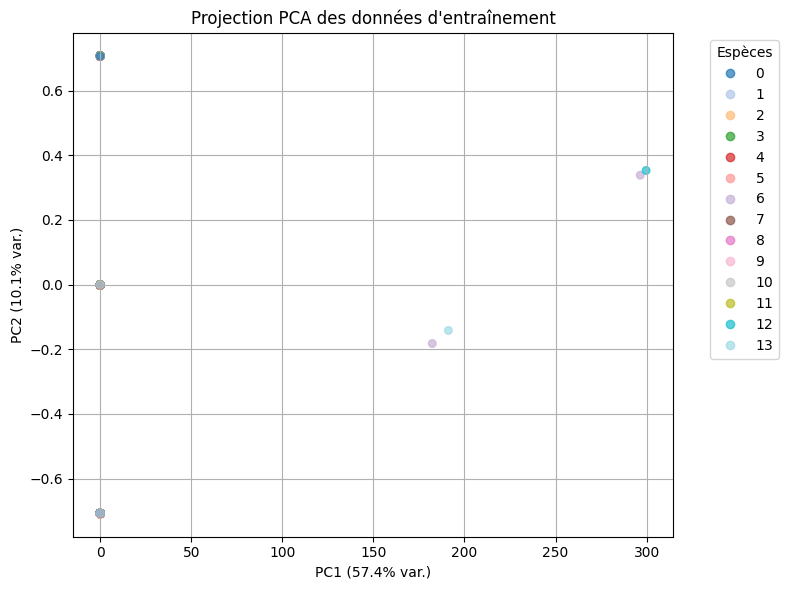

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Encodage y_train en 0,1,2,...
# le = LabelEncoder()
# y_train_enc = le.fit_transform(y_train)

# # PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_train_proc)

# # scatter avec c numérique
# plt.figure(figsize=(8,6))
# scatter = plt.scatter(
#     X_pca[:,0], X_pca[:,1],
#     c=y_train_enc,
#     cmap='tab20',    # >10 classes
#     alpha=0.7,
#     s=30
# )
# plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)")
# plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)")
# plt.title("Projection PCA des données d'entraînement")

# plt.legend(
#     *scatter.legend_elements(),
#     title="Espèces",
#     bbox_to_anchor=(1.05,1),
#     loc="upper left"
# )
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [ ]:
#print("Pas de clusters distincts : les points (espèces) sont superposés.")

In [6]:
# Calcul de 2 features pour chaque image : brightness & blur

import cv2
import numpy as np
from PIL import Image

# Listes qui stockeront 
#  - stats    : [brightness, blur] pour chaque image
#  - paths    : le chemin correspondant de chaque image
stats, paths = [], []

# On parcourt toutes les lignes du DataFrame df
for i, row in df.iterrows():
    # Chargement en niveau de gris (1 canal)
    img = cv2.imread(row["image_path"], cv2.IMREAD_GRAYSCALE) 

    # Si l’image n’a pas pu être lue (chemin incorrect, fichier corrompu…)
    if img is None:
        continue
    
    #  Brightness = luminosité moyenne de tous les pixels
    brightness = float(img.mean())
    
    # Blur metric = estimation de la netteté via la variance du Laplacien. Plus c’est élevé, plus l’image est nette
    blur_metric = float(cv2.Laplacian(img, cv2.CV_64F).var())
    
    # On stocke la paire de métriques et le chemin
    stats.append([brightness, blur_metric])
    paths.append(row["image_path"])


In [7]:
# Import de la classe PCA
from sklearn.decomposition import PCA


# Standardisation des deux métriques (brightness et blur) > ramène chaque variable à moyenne 0 et écart-type 1
scaler = StandardScaler()
stats_scaled = scaler.fit_transform(stats) 

# Instanciation de la PCA avec 2 composantes principales
# PC1 et PC2 seront chacune une combinaison linéaire de brightness & blur.
pca = PCA(n_components=2)

# Calcul de la projection : on obtient pour chaque image ses coordonnées dans l'espace réduit à 2 dimensions.
X_pca  = pca.fit_transform(stats_scaled)

# À ce stade :
#  pca.explained_variance_ratio_[0] est la part de variance expliquée par PC1,
#  pca.explained_variance_ratio_[1] celle expliquée par PC2.
#  
# Ensuite, on placera les mini-vignettes à (X_pca[i,0], X_pca[i,1])
# pour visualiser les images le long de ces deux axes “qualité d’image”.

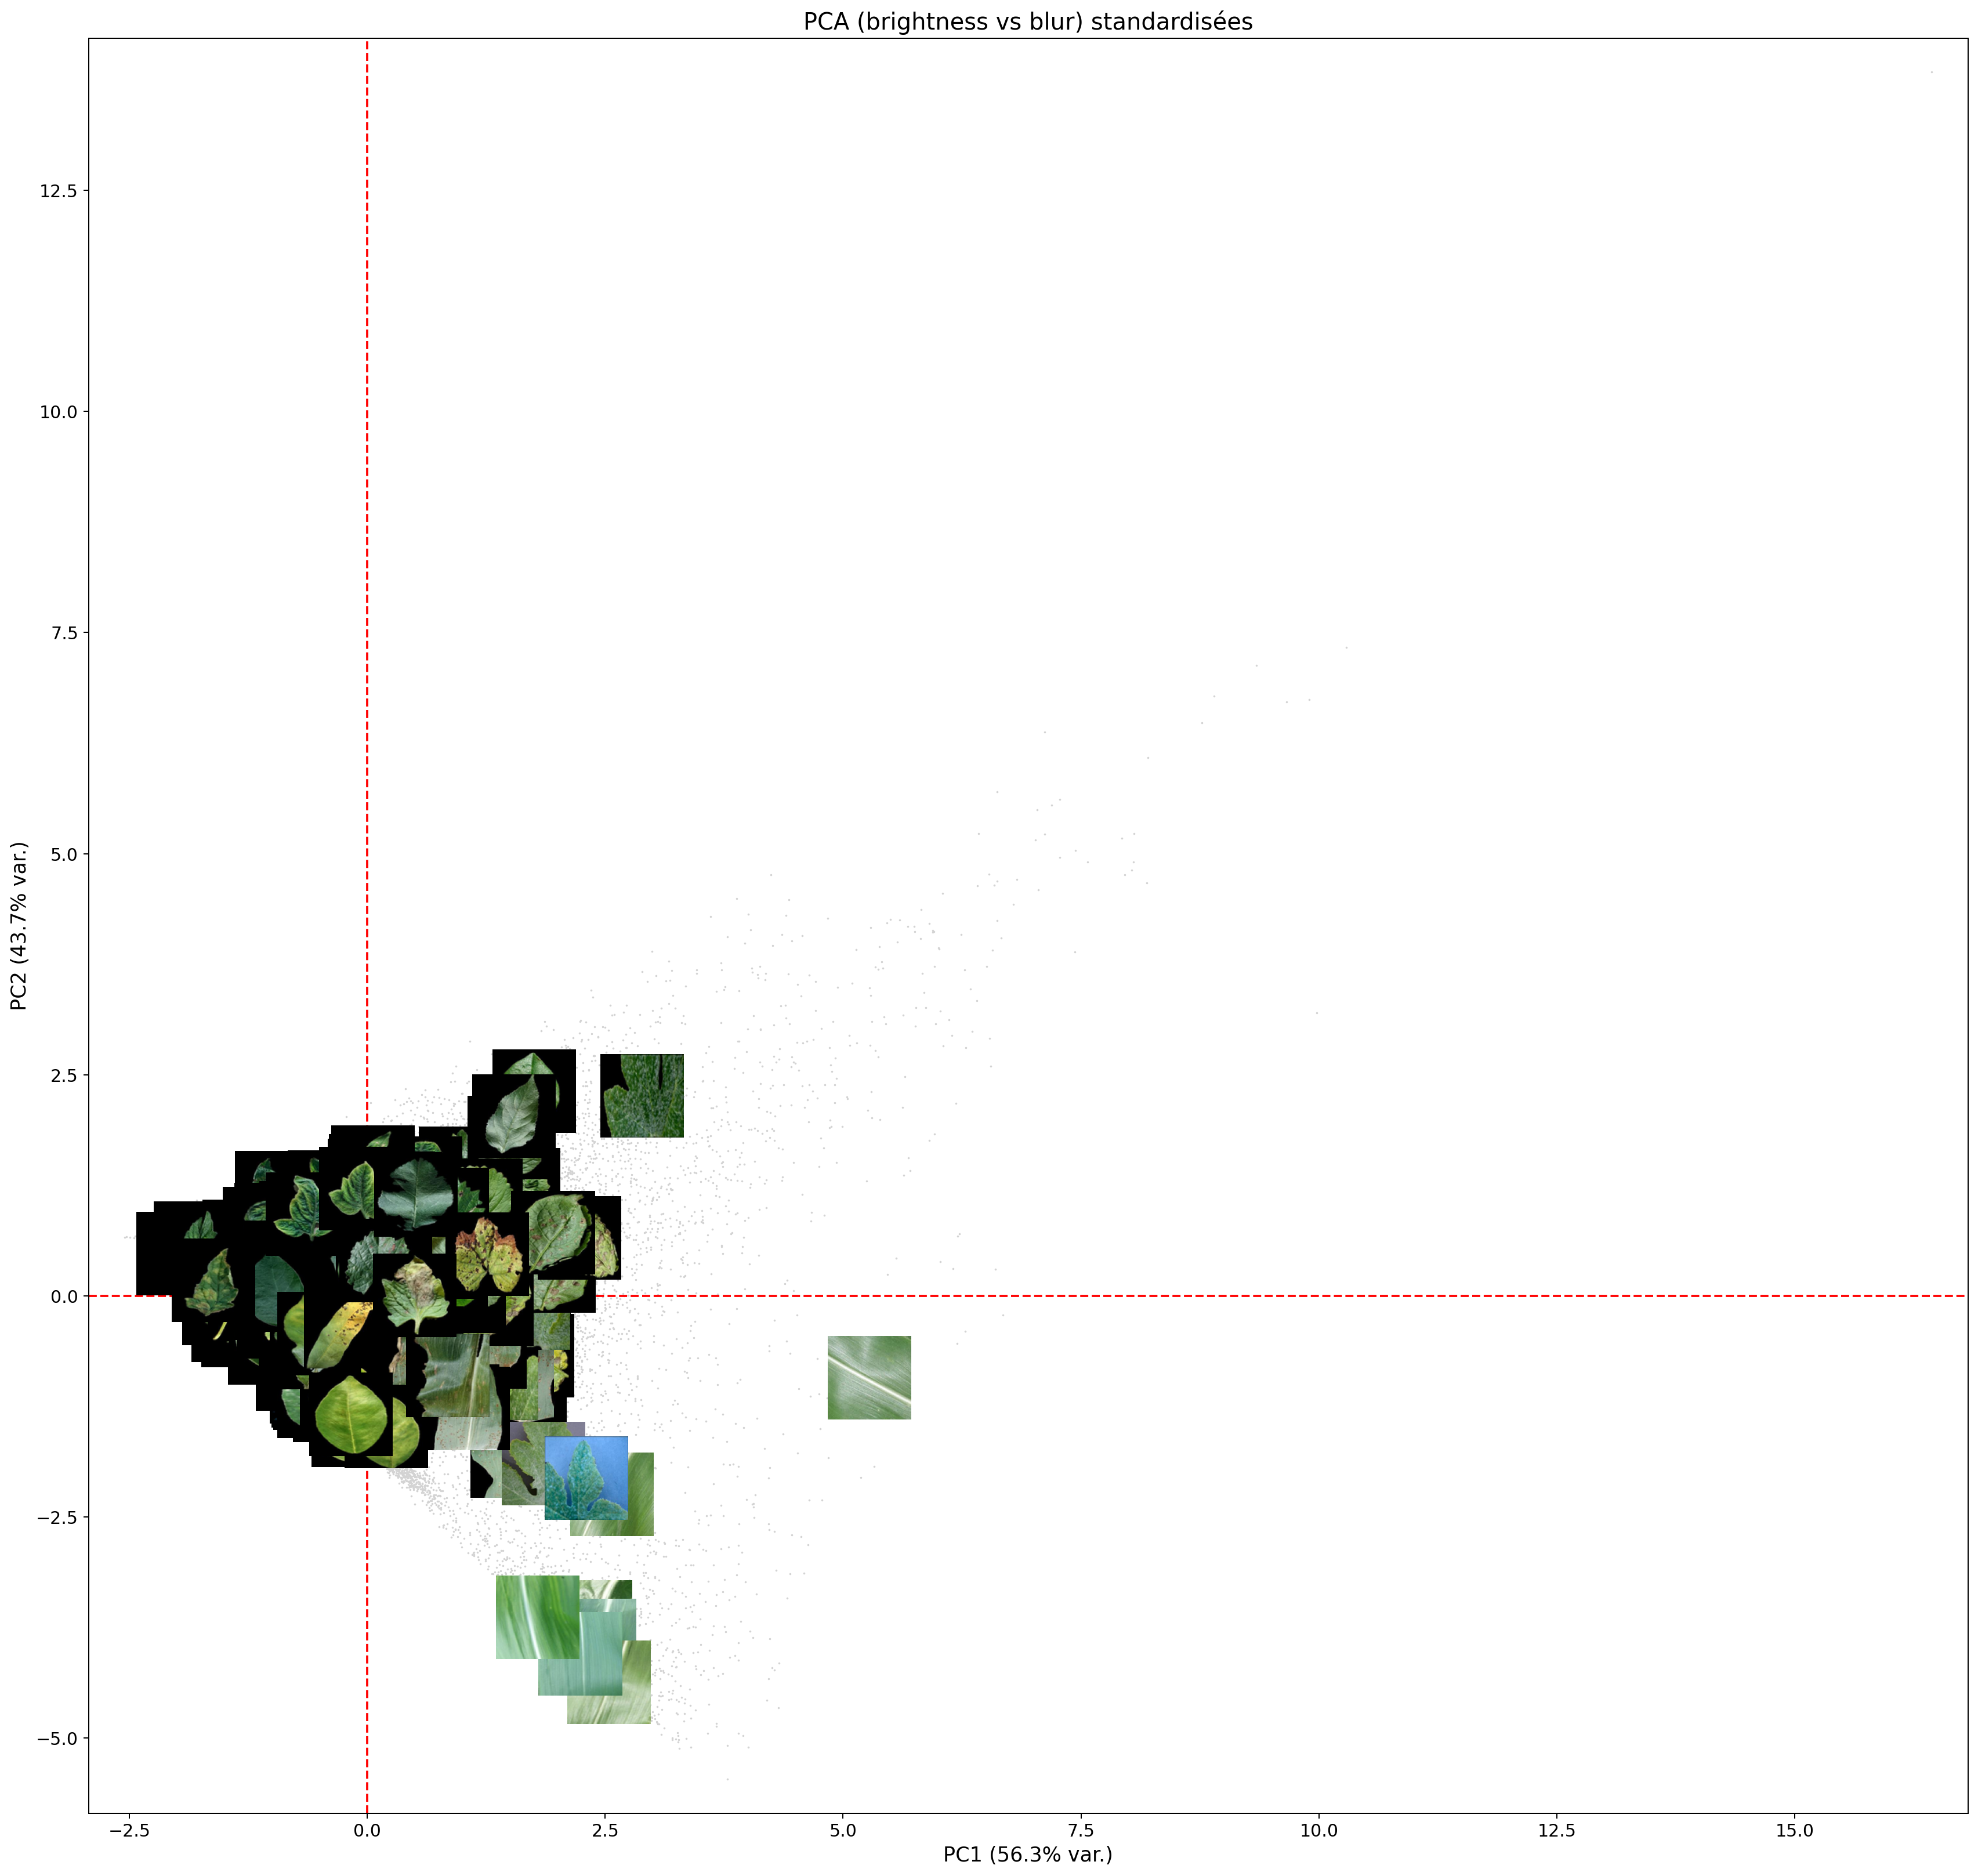

<Figure size 640x480 with 0 Axes>

In [124]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# ----------------------------------------------------------------------
# FONCTION : créer une mini‐image (thumbnail) à partir d’un chemin de fichier
# ----------------------------------------------------------------------
def make_thumb(path, zoom=0.6, size=(96,96)):
    """
    - path : chemin vers l'image
    - zoom : facteur d'agrandissement pour l'affichage (1.0 = taille réelle du thumbnail)
    - size : dimension max (largeur, hauteur) du thumbnail en pixels
    """
    # on ouvre l'image et on s'assure d'être en RGB
    im = Image.open(path).convert("RGB")
    # on redimensionne en conservant le ratio, avec un filtre LANCZOS
    try:
        im.thumbnail(size, Image.Resampling.LANCZOS)
    except AttributeError:
        im.thumbnail(size, Image.LANCZOS)
    # on transforme en numpy array et on encapsule dans un OffsetImage
    return OffsetImage(np.array(im), zoom=zoom)

# ----------------------------------------------------------------------
# INITIALISATION DE LA FIGURE
# ----------------------------------------------------------------------
# figsize : taille en pouces (largeur, hauteur)
# dpi     : points par pouce (résolution)
fig, ax = plt.subplots(figsize=(20,20), dpi=180)

# nuage global « gris clair » en arrière-plan
sc = ax.scatter(
    X_pca[:,0], X_pca[:,1],
    s=2, c="lightgray", linewidth=0
)

# calcul des moyennes
mu_x, mu_y = X_pca[:,0].mean(), X_pca[:,1].mean()

# tracage en surimpression
ax.axvline(mu_x, color="red", linestyle="--", linewidth=1.5, label=f"μ(PC1)={mu_x:.2f}")
ax.axhline(mu_y, color="red", linestyle="--", linewidth=1.5, label=f"μ(PC2)={mu_y:.2f}")

# On affiche la variance expliquée par chacune des 2 PC
ax.set_title("PCA (brightness vs blur) standardisées", fontsize=16)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)", fontsize=14)
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)", fontsize=14)
ax.tick_params(axis="both", which="major", labelsize=12)

# ----------------------------------------------------------------------
# SOUS‐ÉCHANTILLONNAGE pour la lisibilité
# ----------------------------------------------------------------------
rng = np.random.RandomState(7) 
# Pour ne pas surcharger le graphe, on n'affiche que 250 images au hasard
n_samples = len(X_pca)
indices = rng.choice(n_samples, size=250, replace=False)

# ----------------------------------------------------------------------
# AJOUT DES MINI‐VIGNETTES
# ----------------------------------------------------------------------
for i in indices:
    # On récupère les coordonnées (PC1, PC2)
    x,y = X_pca[i]
    # On crée la vignette
    thumb = make_thumb(paths[i])
    # frameon=False : pas de bordure autour de la vignette
    ab = AnnotationBbox(thumb, (x,y), frameon=False)
    ax.add_artist(ab)

fig.subplots_adjust(left=0.05,   # bord gauche
                    right=0.95,  # bord droit
                    bottom=0.05, # bord bas
                    top=0.90)    # bord haut
ax.margins(x=0.02, y=0.02)
plt.show();
# ----------------------------------------------------------------------
# RECADRAGE AUTOMATIQUE
# ----------------------------------------------------------------------

# calculer les bornes centrées sur 90 % des données
x_min, x_max = np.percentile(X_pca[:,0], [5, 95])
y_min, y_max = np.percentile(X_pca[:,1], [5, 95])

# ajouter un petit padding (ici 10 % de la plage)
dx = (x_max - x_min) * 0.1
dy = (y_max - y_min) * 0.1

ax.set_xlim(x_min - dx, x_max + dx)
ax.set_ylim(y_min - dy, y_max + dy)


# ----------------------------------------------------------------------
# AFFICHAGE FINAL
# ----------------------------------------------------------------------
ax.grid(True)
plt.tight_layout()
plt.show()

In [119]:
print("PC1 (horizontal, 56 % de la variance) : luminosité standardisée. À gauche : images très sombres. À droite : images très claires")
print("PC2 (vertical, 44 % de la variance) : netteté (variance du Laplacien standardisée. En bas : images très floues . En haut : images très nettes")
print("Ligne verticale au niveau de la moyenne de PC1, et horizontale au niveau de la moyenne de PC2 > La majorité des images est autour de (PC1 environ 2.5, PC2 environ 0) et sera exploitable")
print("La majorité des images se trouve dans la zone centrale (luminosité et netteté moyennes) > seront probablement faciles à traiter par notre modèle.")
print("le quadrant en Bas-Gauche regroupe les images qui sont à la fois sombres et floues : intraitables?")
print("Il y a des outliers : images trop claires. A filtrer ?")



PC1 (horizontal, 56 % de la variance) : luminosité standardisée. À gauche : images très sombres. À droite : images très claires
PC2 (vertical, 44 % de la variance) : netteté (variance du Laplacien standardisée. En bas : images très floues . En haut : images très nettes
Ligne verticale au niveau de la moyenne de PC1, et horizontale au niveau de la moyenne de PC2 > La majorité des images est autour de (PC1 environ 2.5, PC2 environ 0) et sera exploitable
La majorité des images se trouve dans la zone centrale (luminosité et netteté moyennes) > seront probablement faciles à traiter par notre modèle.
le quadrant en Bas-Gauche regroupe les images qui sont à la fois sombres et floues : intraitables?
Il y a des outliers : images trop claires. A filtrer ?


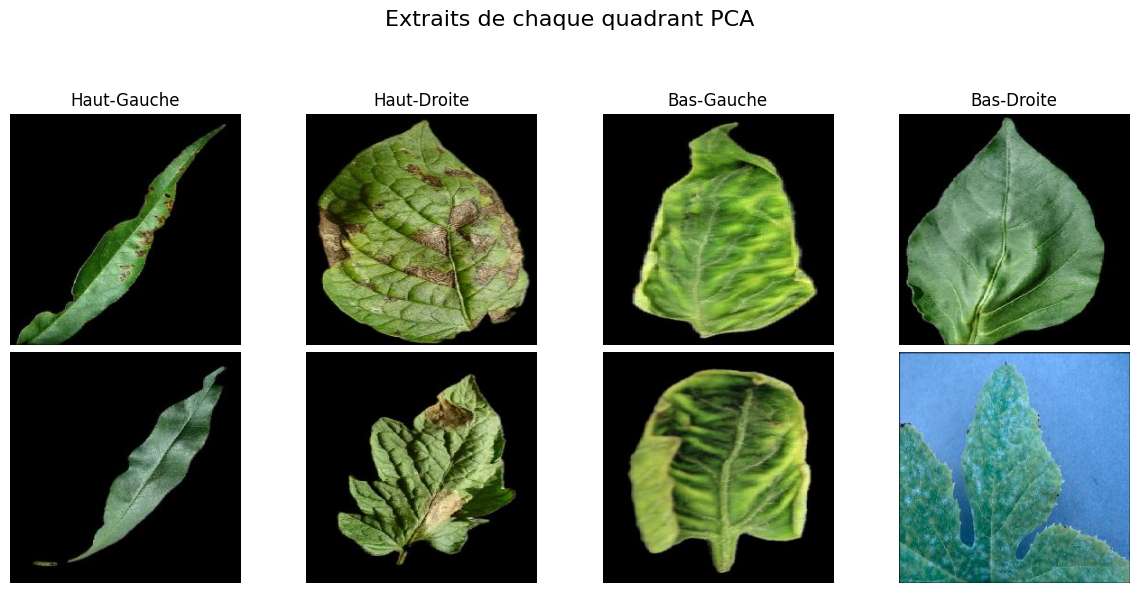

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# On reprend exactement la même sous‐échantillonnage ———
rng = np.random.RandomState(7)   # même graine qu’en amont
n_samples = len(X_pca)
indices = rng.choice(n_samples, size=150, replace=False)

# On découpe en 4 quadrants par rapport aux médianes de PC1 et PC2 ———
med1 = np.median(X_pca[:,0])
med2 = np.median(X_pca[:,1])

# dictionnaire {nom_quadrant: liste_d’indices}
quadrants = {"Haut-Gauche": [], "Haut-Droite": [], "Bas-Gauche": [], "Bas-Droite": []}
for i in indices:
    x,y = X_pca[i]
    if   x<=med1 and y> med2: quadrants["Haut-Gauche"].append(i)
    elif x> med1  and y> med2: quadrants["Haut-Droite"].append(i)
    elif x<=med1 and y<=med2: quadrants["Bas-Gauche"].append(i)
    else:                      quadrants["Bas-Droite"].append(i)

# Pour chaque quadrant on tire 2 images (ou moins si pas assez) ———
pick = {}
for name, lst in quadrants.items():
    if len(lst)<=2:
        pick[name] = lst
    else:
        pick[name] = rng.choice(lst, size=2, replace=False)

# Affichage en grille 2×4 ———
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Extraits de chaque quadrant PCA", fontsize=16)

# on parcourt les colonnes (chaque quadrant)
for col, (name, idxs) in enumerate(pick.items()):
    # titre au-dessus de la colonne
    axes[0, col].set_title(name, fontsize=12)
    # on enlève les axes de fond
    axes[0, col].axis("off")
    axes[1, col].axis("off")
    # on affiche jusqu'à 2 images, une par ligne
    for row, idx in enumerate(idxs):
        img = Image.open(paths[idx]).convert("RGB")
        axes[row, col].imshow(img)
        axes[row, col].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


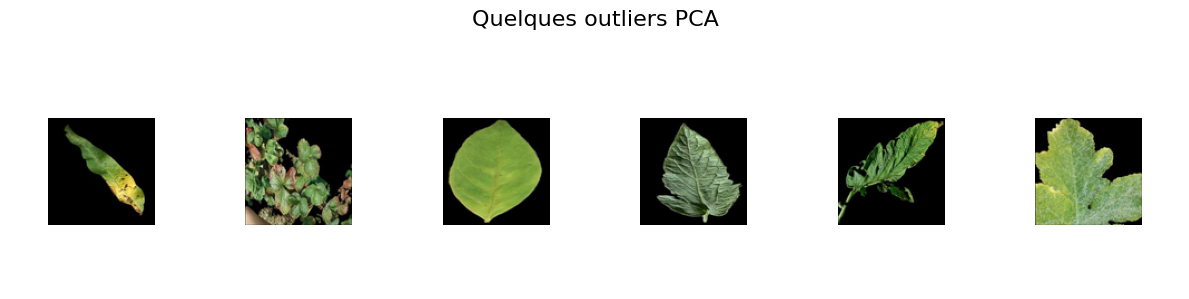

In [106]:
# bornes « internes »
lo1, hi1 = np.percentile(X_pca[:,0], [5, 95])
lo2, hi2 = np.percentile(X_pca[:,1], [5, 95])

# masque d’outliers
mask_out = (
  (X_pca[:,0] < lo1) | (X_pca[:,0] > hi1) |
  (X_pca[:,1] < lo2) | (X_pca[:,1] > hi2)
)
idxs_out = np.where(mask_out)[0]

rng = np.random.RandomState(7)
sample_out = rng.choice(idxs_out, size=min(6, len(idxs_out)), replace=False)

fig, axes = plt.subplots(1, len(sample_out), figsize=(2*len(sample_out), 3))
fig.suptitle("Quelques outliers PCA", fontsize=16)
for ax, idx in zip(axes, sample_out):
    thumb = make_thumb(paths[idx], zoom=0.8)
    ab = AnnotationBbox(thumb, (0.5,0.5), frameon=False,
                        xycoords='axes fraction')
    ax.add_artist(ab)
    ax.axis("off")
plt.tight_layout()
plt.show()
